# Stanley Controller following a straight line

We need the follwing packages to be installed: `numpy` and `matplotlib` and `scipy`.
Additionally we need the follwing python files (should be placed in the same folder): `Model_Vehicle.py` and `Trajectory_LaneChange.py`<br>

Literature explaing the controller can be found e.g. at:<br>
G. M. Hoffmann, C. J. Tomlin, M. Montemerlo, and S. Thrun, “Autonomous Automobile Trajectory Tracking for Off-Road Driving : Controller Design , Experimental Validation and Racing †,” pp. 2296–2301, 2007
http://ai.stanford.edu/~gabeh/papers/hoffmann_stanley_control07.pdf

In [1]:
import numpy as np
from numpy import cos, sin, tan, arcsin, arctan2, pi

import scipy.integrate as sci

from Model_Vehicle import *
from Trajectory_LaneChange import referenceTrajectory
#from Trajectory_Straight import referenceTrajectory

#from vehiclemodels.parameters_vehicle2 import parameters_vehicle2
from test_vehicle import func_MB, x0_MB, func_ST, x0_ST
from scipy.integrate import odeint


We bundle all parameters within a seperate class `Parameters` to access them.
Two instances distinguish physical from simulation parameters.
These parameters are used to specify the vehicle and experiment setup.

In [2]:
class Parameters(object):
    pass

# Physical parameter
# para     = Parameters()  # instance of class Parameters
# para.l   = 2.850         # define car length [m]
# para.w   = para.l * 0.3  # define car width [m]
# para.ref_l = para.l      # define dist to reference point in vehicle (from rear)
# para.k   = 10            # K
# para.ksoft = 1
# para.dt  = 0.04          # controller step size [s]
# para.maxDelta = 25 * pi / 180 # [rad]
# para.tFinal = 1
#
# # Simulation parameter
# sim_para = Parameters()  # instance of class Parameters
# sim_para.t0 = 0          # start time
# sim_para.tf = 2          # final time
# sim_para.dt = para.dt    # step-size


para = Parameters()  # instance of class Parameters
para.l = 2.850  # car length in [m]
para.lr = 1.268 / (1.620 + 1.268) * 2.850  # real length [m]
para.lf = 1.620 / (1.620 + 1.268) * 2.850  # front length [m]
para.w = para.l * 0.3  # define car width [m]
para.k = 10  # [1/s] tuning for cross tracking error 1...20 seems reasonable, DARPA 2.5?
para.ksoft = 1.0  # [m/s] to avoid problems as low speeds close or equal to zero
para.dt = 1.0 / 25.0  # controller step size [s]
para.maxDelta = 25 * pi / 180  # [rad]
para.ref_l = para.l
para.tFinal = 1
para.l_R = 0.5 * para.l
para.t_LA = 6
para.EG = 4

# Simulation parameter
sim_para = Parameters()  # instance of class Parameters
sim_para.t0 = 0  # start time
sim_para.tf = 3  # final time
sim_para.dt = para.dt  # step-size

In the next cell the controller is defined in `control` as well as the control error calculation that is controller specific and defined in `controlErrorEGOFront`.

In [3]:
def controlStanley(e, xc, p, t):
    """Function of the control law
    Args:
        e: error vector
        xc: state vector of controller (discrete states from last iteration)
        t: time
    Returns:
        u: control vector
        xc: updated state vector controller
    """
    e_fa, theta_e = e  # decompose error

    vx = p.vx
    u1 = vx  # set control vx

    # simple stanley control
    steering_angle = theta_e + arctan2(p.k * e_fa, vx + p.ksoft)

    # normalize and limit
    steering_angle = arcsin(sin(steering_angle))
    steering_angle = np.minimum(np.maximum(steering_angle, -p.maxDelta), p.maxDelta)

    # turn rate
    # turn_rate = vx / p.l * tan( steering_angle )

    # steering acc
    return np.array([u1, steering_angle]).T, xc





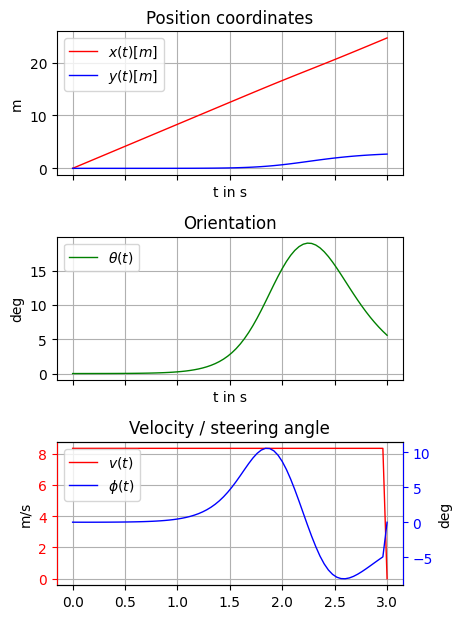

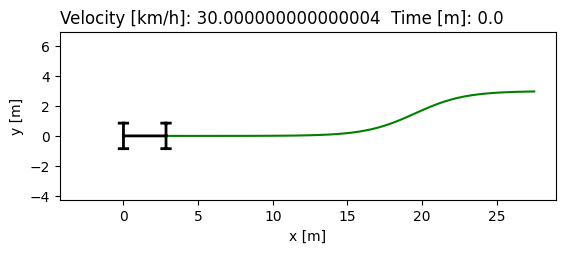

In [4]:
from CarControl_Stanley2 import getTargetPoint2


##################################################################################
def control(e, xc, p, t):
    """Function of the control law
    Args:
        e:  control error (controller specific)
        xc: state vector controller from last step (only applies for controller with internal states)
        t:  time (to enable time dependent control laws like fade in/out etc.)
    Returns:
        u:  control vector
        xc: updated state vector controller (save internal state for next call)
    """
    e_fa, theta_e = e                          # extract two parts of the control error

    vx = p.vx                                  # get the vehicle velocity (const parameter)
    u1 = vx

    u2= u1        # ADD here the control
    u2 = np.minimum(np.maximum(u2, -p.maxDelta), p.maxDelta)

    # saturation of steering angle


    # steering acc
    return np.array([-10, np.deg2rad(45)]).T, xc

##################################################################################
def controlErrorEGOFront(ego_state, r, t, p):
    # calaculate the error with respect to the front

    x, y, theta = ego_state  # extract state vector from ego_state
    ego_pos = np.array([(x + p.l * cos(theta)), (y + p.l * sin(theta))])  # ego position vector

    target_pos, target_psi = getTargetPoint2(ego_pos, r_traj)  # extract target position and orientation

    # POSITION ERROR
    error_vect = ego_pos - target_pos  # vector VA from target to ego
    traj_vect = np.array([cos(target_psi), sin(target_psi)])  # vector VB from target along road
    crossProd_z = error_vect[0] * traj_vect[1] - error_vect[1] * traj_vect[0]  # z of cross VA x VB
    e_fa = np.linalg.norm(target_pos - ego_pos)  # distance error (absolute)
    if crossProd_z < 0:  # check if left or right
        e_fa = -e_fa  # vehicle is left of trajectory

    # ORIENTATION ERROR
    theta_e = target_psi - theta  # orientation error

    return np.array([e_fa, theta_e]).T

Next the controller and the vehicle are simulated in closed loop.
Initial states (position) can be changed to investigate the reaction
to offsets.

In [5]:
# initial state ##################################################################
sim_para.x0 = [0, 0, 0]
sim_para.xc0 = [0,0] # controller states
para.vx = 30 / 3.6  # vehicle speed

The reference trajectory is provided within a predifined subfunction `referenceTrajectory`

In [6]:
from vehiclemodels.parameters_vehicle2 import parameters_vehicle2
from test_vehicle import func_MB, x0_MB
from scipy.integrate import odeint

# reference ######################################################################
r_traj = referenceTrajectory(para, sim_para)
t = np.arange(0, para.tFinal, para.dt)
v_delta = 0.0
acc = 0
u = [v_delta, acc]

p = parameters_vehicle2()
p.vx = para.vx
#p.l_R = 0.5 * para.l

# simulate car
x_brake = odeint(func_MB, x0_MB, t, args=(u, p))

## mb braking


Simulation is executed and resulting states are saved.

# MB Breaking


In [7]:
from vehiclemodels.init_mb import init_mb
from CarControl_Stanley2 import controlErrorEGOFront2, controlStanley2, controlStanleyCopy, referenceTrajectory2, \
    car_animation2, controlErrorEGOFrontSimple, controlStanleySimple
from vehiclemodels.vehicle_dynamics_ks import vehicle_dynamics_ks
from test_vehicle import func_KS, x0_KS
from vehiclemodels.vehicle_dynamics_st import vehicle_dynamics_st
from vehiclemodels.vehicle_dynamics_mb import vehicle_dynamics_mb

# ref
from Trajectory_LaneChange import referenceTrajectory
r_traj = referenceTrajectory2(para, sim_para)

# simulation #####################################################################
tt = np.arange(sim_para.t0, sim_para.tf + sim_para.dt, sim_para.dt)  # time vector

x_brake = odeint(func_MB, x0_MB, tt, args=(u, p))

#x_traj = np.zeros([len(tt), len(sim_para.x0)])  # init state trace
#x_traj[0, :] = sim_para.x0  # set initial state

x_traj = np.zeros([len(tt), len(x_brake[0, :])])
x_traj[0, :] = x_brake[0, :]
#x_traj[0][2] = 0 #steering angle
x_traj[0][3] = para.vx #velocity x


u_traj = np.zeros([len(tt), 2])
xc = [0, 0]  # controller states
e_traj = np.zeros([len(tt), 2])  # init state trace
xc = sim_para.xc0

# breaking
v_delta = 0.0
acc = 0
u = [v_delta, acc]

# begin initial state dynamics prep
x_init = x_brake[0, :]
# set velocity to initial value
x_init[2] = 0
x_init[3] = para.vx
# end initial state dynamics prep

for t_i in np.arange(len(tt) - 1):  # loop over time instances

    # error model
    e_traj[t_i] = controlErrorEGOFrontSimple(x_traj[t_i, [0, 1, 6]], r_traj, tt[t_i], para)
    # control law
    para.u, xc = controlStanley2(e_traj[t_i], xc, para, tt[t_i])  # get control
    # [steering angle, velocity]
    u_traj[t_i] = para.u

    # vehicle motion
    sol = sci.solve_ivp(lambda t, x: vehicle_dynamics_mb(x, para.u, p),
                        (tt[t_i], tt[t_i + 1]), x_traj[t_i, :],
                        method='RK45', t_eval=tt[t_i + 1:t_i + 2])
    #x_init = sol.y.T[0]
    x_traj[t_i + 1, :] = sol.y.T  # size = len(x) x len(tt) (.T -> transpose)

# plot ###########################################################################
plt.rcParams['figure.dpi'] = 100
plot_data(x_traj[:, [0, 1, 6]], u_traj, r_traj, tt, 12, 16, 'state_trajectory_Stanley_Straight', save=False)
plt.show()
#
#
# animation ######################################################################
plt.rcParams['figure.dpi'] = 200
ani = car_animation2(x_traj[:, [0, 1, 6]], u_traj, r_traj, tt, para)#, x_traj, 'state_trajectory_Stanley_Straight')
plt.show()
plt.close()
ani




KeyboardInterrupt

